# <center>CAT Reloaded Data Science Competition 2.0</center><br><center>Car price prediction</center>

## Importing Packages & Data

In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For modeling
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor

from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split

# For preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    RobustScaler,
)

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

## Data Exploration

In [3]:
train.head()

,ID,Brand,VehicleModel,ManufacturingYear,Type,rating,color,Duty,fuel,CylinderCount,type of gear,capacity,Odometer,#airbags,price
0,2624,NaN,I have the fastest model ever.. yes you got it...,2017,WOOW Sedan,0.0,NaN,I had to pay a substantial $1249 levy on my ne...,Gas,4.0,R,2.5,75492 KM,1008,21012
1,14392,I love TOYOTA,NaN,NaN,Minivan3,5.0,Metallic,-,Gas,4.0 cyl,R,2.4,220000 KM,-96,11917
2,9822,hyundai,H1,2009,MINIVAN,0.0,Metallic,1185$,Dies,4.0,R,2.5,TOTAL 50653 km,4 count,22433
3,17123,opel,Corsa,NaN,Hatchback,5.0,Jet Black,-,NaN,4.0,auto,0,230000 KM,0,5645
4,11133,subaru,I own Outback.,2007,Hatchback,4.0,Sapphire Blue,-,Gas,4.0,NaN,2.5,131000 KM,4,10976


In [4]:
train.shape

(7000, 15)

In [5]:
train.describe(include='object')

,Brand,VehicleModel,ManufacturingYear,Type,color,Duty,fuel,CylinderCount,type of gear,capacity,Odometer,#airbags
count,6294,6303,6305,6315,4876,7000,6304,7000,6308,7000,7000,7000
unique,185,1480,555,81,16,1173,7,28,7,87,4964,321
top,toyota,Prius,2012,sedan,Jet Black,-,Gas,4.0,auto,2,0 km,12
freq,497,113,429,1160,1239,2108,3272,2638,2870,1261,79,830


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 7000 non-null   int64  
 1   Brand              6294 non-null   object 
 2   VehicleModel       6303 non-null   object 
 3   ManufacturingYear  6305 non-null   object 
 4   Type               6315 non-null   object 
 5   rating             6310 non-null   float64
 6   color              4876 non-null   object 
 7   Duty               7000 non-null   object 
 8   fuel               6304 non-null   object 
 9   CylinderCount      7000 non-null   object 
 10  type of gear       6308 non-null   object 
 11  capacity           7000 non-null   object 
 12  Odometer           7000 non-null   object 
 13  #airbags           7000 non-null   object 
 14  price              7000 non-null   int64  
dtypes: float64(1), int64(2), object(12)
memory usage: 820.4+ KB


In [7]:
train.duplicated().sum()

0

In [8]:
train.isna().sum()

ID                      0
Brand                 706
VehicleModel          697
ManufacturingYear     695
Type                  685
rating                690
color                2124
Duty                    0
fuel                  696
CylinderCount           0
type of gear          692
capacity                0
Odometer                0
#airbags                0
price                   0
dtype: int64

In [9]:
test.columns

Index(['ID', 'Brand', 'VehicleModel', 'ManufacturingYear', 'Type', 'rating',
       'color', 'Duty', 'fuel', 'CylinderCount', 'type of gear', 'capacity',
       'Odometer', '#airbags'],
      dtype='object')

## Cleaning

### `ID` Column

In [10]:
id = train['ID']
id_test = test['ID']

train.drop(columns='ID', inplace=True)
test.drop(columns='ID', inplace=True)

### `Brand` Column

In [11]:
train['Brand'].str.lower().sort_values().unique()

array(['acura', 'alfa romeo', 'audi', 'audi is the best', 'bmw',
       'bmw is the best', 'buick', 'cadillac', 'chevrolet',
       'chevrolet is the best', 'chrysler', 'citroen', 'daewoo',
       'daewoo is the best', 'daihatsu', 'daihatsu is the best', 'dodge',
       'dodge is the best', 'fiat', 'fiat is the best', 'ford',
       'ford is the best', 'gaz', 'gmc', 'greatwall', 'honda',
       'honda is the best', 'hyundai', 'hyundai is the best',
       'i love audi', 'i love bmw', 'i love cadillac', 'i love chevrolet',
       'i love citroen', 'i love daewoo', 'i love dodge', 'i love fiat',
       'i love ford', 'i love gaz', 'i love honda', 'i love hyundai',
       'i love jeep', 'i love kia', 'i love land rover', 'i love lexus',
       'i love mazda', 'i love mercedes-benz', 'i love mini',
       'i love mitsubishi', 'i love nissan', 'i love opel',
       'i love porsche', 'i love skoda', 'i love ssangyong',
       'i love subaru', 'i love suzuki', 'i love toyota', 'i love vaz',
 

In [12]:
train['Brand'] = (
    train['Brand']
    .str.lower()
    .str.replace('i love', '')
    .str.replace('is the best', '')
    .str.strip()
)

In [13]:
train['Brand'].isna().sum()

706

In [14]:
train['Brand'].value_counts()

Brand
toyota           1246
hyundai          1225
mercedes-benz     651
chevrolet         362
ford              353
bmw               333
honda             325
lexus             279
nissan            216
volkswagen        194
ssangyong         163
kia               155
opel              139
subaru            105
mitsubishi         96
audi               78
mazda              61
jeep               44
dodge              30
daewoo             30
fiat               30
suzuki             24
renault            13
jaguar             12
vaz                11
mini               11
porsche            11
lincoln            10
land rover          9
peugeot             7
volvo               7
skoda               7
infiniti            7
buick               6
daihatsu            5
uaz                 5
gaz                 4
chrysler            3
citroen             3
cadillac            3
scion               3
moskvich            2
mercury             2
alfa romeo          2
gmc                 2
acur

In [15]:
test['Brand'] = (
    test['Brand']
    .str.lower()
    .str.replace('i love', '')
    .str.replace('is the best', '')
    .str.strip()
)

brand_counts_test = test['Brand'].value_counts()

### `VechileModel` Column

In [16]:
train['VehicleModel'].str.lower().sort_values().unique()

array(['100', '1000', '116', ..., 'z4', 'zafira', nan], dtype=object)

This code block performs several operations to clean and standardize the `VehicleModel` column:

1. Converts all text to lowercase
2. Removes various extraneous phrases and punctuation
3. Strips leading and trailing whitespace
4. Extracts only the first word of the remaining text

This process helps to normalize the vehicle model data, reducing noise and inconsistencies in the dataset.<br>The resulting `VehicleModel` column should contain more uniform and usable data for further analysis.

In [17]:
train['VehicleModel'] = (
    train['VehicleModel']
    .str.lower()
    .str.replace('my model which is', '')
    .str.replace('is the best', '')
    .str.replace('i own', '')
    .str.replace("i have the fastest model ever.. yes you got it right it's", '')
    .str.replace("i have the fastest model ever yes you got it right it's", '')
    .str.replace('.', '')
    .str.strip()
)

train['VehicleModel'] = train['VehicleModel'].str.split().str[0]

In [18]:
test['VehicleModel'] = (
    test['VehicleModel']
    .str.lower()
    .str.replace('my model which is', '')
    .str.replace('is the best', '')
    .str.replace('i own', '')
    .str.replace("i have the fastest model ever.. yes you got it right it's", '')
    .str.replace("i have the fastest model ever yes you got it right it's", '')
    .str.replace('.', '')
    .str.strip()
)

test['VehicleModel'] = test['VehicleModel'].str.split().str[0]

In [19]:
train['VehicleModel'].value_counts()

VehicleModel
prius       437
sonata      369
camry       341
elantra     329
e           255
           ... 
coltplus      1
rasheen       1
stella        1
c8            1
x-type        1
Name: count, Length: 429, dtype: int64

### `ManfactruingYear` Column

To clean and standardize the `ManufacturingYear` column in our dataset, we've implemented two custom functions:

1. `extract_4digits_year(text)`: This function extracts a 4-digit year from the input text.
   - It uses a regular expression `\d{4}` to find the first occurrence of four consecutive digits.
   - If found, it returns the 4-digit year; otherwise, it returns the original text.

2. `extract_years_ago(text)`: This function converts text in the format "X years old" to an actual year.
   - It uses a regular expression `^(\d+)years old$` to match text in the format "X years old".
   - If matched, it subtracts the number of years from the current year (2024) to get the manufacturing year.
   - If no match is found, it returns the original text.

We then apply these functions sequentially to the `ManufacturingYear` column:

In [20]:
def extract_4digits_year(text):
    if pd.notna(text):
        year_match = re.search(r'\d{4}', str(text))
        if year_match:
            return year_match.group(0)
    return text

def extract_years_ago(text):
    if pd.notna(text):
        year_match = re.search(r'^(\d+)years old$', str(text))
        if year_match:
            year = year_match.group(1)
            return 2024 - int(year)
            
    return text

In [21]:
train['ManufacturingYear'] = train['ManufacturingYear'].apply(extract_4digits_year)
train['ManufacturingYear'] = train['ManufacturingYear'].apply(extract_years_ago)

In [22]:
train['ManufacturingYear'].unique()

array(['2017', nan, '2009', '2007', '3010', '1999', '2012', '2011',
       '2014', '2015', '2006', '2105', '2013', '2010', '2003', '2016',
       '1998', '2018', '2008', '2111', '2020', '2005', '2004', '1910',
       '1914', '3009', 2010, '2001', '2112', '1997', '1917', 2009, '1916',
       '1912', '2002', '2110', '2115', '2019', 2014, '3013', '1907',
       '2000', '1996', 2012, 2011, '3014', 2013, 2017, '3004', '1913',
       '1900', '1902', '2117', 2016, '2118', '1995', 2018, '2113', '3012',
       '1915', 2015, '1911', 2003, '2116', '2098', 1998, '1918', '2114',
       '3008', '3006', 1996, '2107', '2119', '1908', 2000, '1992', '2099',
       2004, '1985', '1909', '3007', '2103', 2001, '1905', 1991, '1983',
       '3011', '2104', '3015', '1904', '1993', 2007, '1994', '1988',
       '3017', 1999, '1898', '1903', '3018', '2998', '3016', 2005, 2008,
       '1982', 1995, '2108', 2006, 2019, '2106', '3003', '1896', '2100',
       '1893', '1987', '1991', 2002, '2120', '1990', '2102', '30

In [23]:
train['ManufacturingYear'] = train['ManufacturingYear'].astype(float)

- Manipulated dates like (3023, 2998) could be reversed to the original format<br>
by subtracting 1000 from theme

- Other dates like (2119, 2099) could be reversed by removing 100 from theme

In [24]:
train.loc[train['ManufacturingYear'] > 2200, 'ManufacturingYear'].unique()

array([3010., 3009., 3013., 3014., 3004., 3012., 3008., 3006., 3007.,
       3011., 3015., 3017., 3018., 2998., 3016., 3003., 3005., 2999.,
       3019., 3002., 3000., 2992., 3001., 2997.])

In [25]:
train.loc[train['ManufacturingYear'] > 2200, 'ManufacturingYear'] -= 1000

In [26]:
train['ManufacturingYear'].unique()

array([2017.,   nan, 2009., 2007., 2010., 1999., 2012., 2011., 2014.,
       2015., 2006., 2105., 2013., 2003., 2016., 1998., 2018., 2008.,
       2111., 2020., 2005., 2004., 1910., 1914., 2001., 2112., 1997.,
       1917., 1916., 1912., 2002., 2110., 2115., 2019., 1907., 2000.,
       1996., 1913., 1900., 1902., 2117., 2118., 1995., 2113., 1915.,
       1911., 2116., 2098., 1918., 2114., 2107., 2119., 1908., 1992.,
       2099., 1985., 1909., 2103., 1905., 1991., 1983., 2104., 1904.,
       1993., 1994., 1988., 1898., 1903., 1982., 2108., 2106., 1896.,
       2100., 1893., 1987., 2120., 1990., 2102., 2097., 1939., 1919.,
       2096., 2101., 1901., 1953., 1986., 2109., 1984., 1920., 2089.,
       1906., 2093., 1978., 1895.])

In [27]:
train.loc[train['ManufacturingYear'] > 2024, 'ManufacturingYear'].unique()

array([2105., 2111., 2112., 2110., 2115., 2117., 2118., 2113., 2116.,
       2098., 2114., 2107., 2119., 2099., 2103., 2104., 2108., 2106.,
       2100., 2120., 2102., 2097., 2096., 2101., 2109., 2089., 2093.])

In [28]:
train.loc[train['ManufacturingYear'] > 2024, 'ManufacturingYear'] -= 100

In [29]:
test['ManufacturingYear'] = test['ManufacturingYear'].apply(extract_4digits_year)
test['ManufacturingYear'] = test['ManufacturingYear'].apply(extract_years_ago)
test['ManufacturingYear'] = test['ManufacturingYear'].astype(float)

test.loc[test['ManufacturingYear'] > 2200, 'ManufacturingYear'] -= 1000
test.loc[test['ManufacturingYear'] > 2024, 'ManufacturingYear'] -= 100

In [30]:
test['ManufacturingYear'].unique()

array([  nan, 2012., 2006., 2016., 2013., 1906., 2009., 2014., 2015.,
       2004., 2010., 2011., 1912., 2008., 1909., 1910., 2017., 1903.,
       2018., 1994., 2007., 1995., 2005., 1999., 2001., 2003., 1998.,
       1996., 2000., 2019., 1911., 1915., 1913., 1914., 2002., 1899.,
       2020., 1992., 1908., 1997., 1987., 1907., 1991., 1916., 1990.,
       1904., 1918., 1988., 1905., 1989., 1901., 1984., 1980., 1900.,
       1897., 1986., 1917., 1993., 1964.])

In [31]:
train.loc[train['ManufacturingYear'] < 1980, 'ManufacturingYear'] = np.nan
test.loc[test['ManufacturingYear'] < 1980, 'ManufacturingYear'] = np.nan

In [32]:
print(train['ManufacturingYear'].isna().sum())
print(test['ManufacturingYear'].isna().sum())

919
396


### `Type` Column

In [33]:
train['Type'] = (
    train['Type']
    .str.lower()
    .str.replace('woow', '')
    .str.replace(r'\d', '', regex=True)
    .str.strip()
    .replace('', np.nan)
)

In [34]:
test['Type'] = (
    test['Type']
    .str.lower()
    .str.replace('woow', '')
    .str.replace(r'\d', '', regex=True)
    .str.strip()
    .replace('', np.nan)
)

### `Rating` Column

In [35]:
train['rating'].isna().sum()

690

In [36]:
train['rating'].describe()

count    6310.000000
mean        2.559588
std         1.905482
min        -4.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        10.000000
Name: rating, dtype: float64

The purpose is to ensure that the `rating` values fall within a valid range of 0 to 5.

In [37]:
train.loc[train['rating'] < 0, 'rating'] = 0
train.loc[train['rating'] > 5, 'rating'] = 5

In [38]:
train['rating'].value_counts()

rating
2.0    1248
3.0    1175
5.0    1020
0.0    1007
1.0     935
4.0     925
Name: count, dtype: int64

In [39]:
test.loc[test['rating'] < 0, 'rating'] = 0
test.loc[test['rating'] > 5, 'rating'] = 5

In [40]:
train['rating'] = train['rating'].astype(object)
test['rating'] = test['rating'].astype(object)

### `Color` Column

In [41]:
train['color'].value_counts()

color
Jet Black        1239
Pearl White      1083
Metallic          995
Charcoal          628
Sapphire Blue     371
Crimson           166
Emerald Green      77
Tangerine          66
Gold               49
Chocolate          47
Ruby Red           44
Sky Blue           35
Sand               34
Lemon Yellow       30
Royal Purple        7
Rose Pink           5
Name: count, dtype: int64

In [42]:
train['color'] = train['color'].str.lower()

In [43]:
test['color'] = test['color'].str.lower()

### `Duty` Column

In [44]:
train['Duty'].str.lower().sort_values().unique()

array(['!', '"', '#', ..., '|', '}', '~'], dtype=object)

This code snippet processes the `Duty` column:

1. Converts all text in the `Duty` column to lowercase.
2. Creates a boolean mask (`pounds_mask`) identifying rows where the `Duty` column contains the word "pound".
3. Strips non-numeric characters from the `Duty` column, replaces empty strings with NaN, and converts the column to float type.
4. Multiplies the values in the `Duty` column by `POUND_USD_RATE` for rows where the `pounds_mask` is `True`.

The purpose is to standardize and convert duty values to a common currency (USD) for analysis.

In [45]:
POUND_USD_RATE = 1.3

In [46]:
train['Duty'] = train['Duty'].str.lower()

pounds_mask = train['Duty'].str.contains('pound')

train['Duty'] = (
    train['Duty']
    .str.replace(r'\D', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

train.loc[pounds_mask, 'Duty'] *= POUND_USD_RATE

In [47]:
test['Duty'] = test['Duty'].str.lower()

pounds_mask = test['Duty'].str.contains('pound')

test['Duty'] = (
    test['Duty']
    .str.replace(r'\D', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

test.loc[pounds_mask, 'Duty'] *= POUND_USD_RATE

In [48]:
train['Duty'].describe()

count     4422.000000
mean      1893.451606
std       2810.567551
min         87.000000
25%        690.300000
50%        891.000000
75%       1291.000000
max      12455.000000
Name: Duty, dtype: float64

In [49]:
test['Duty'].describe()

count     1893.000000
mean      2002.767987
std       2945.334220
min         87.000000
25%        697.000000
50%        902.200000
75%       1360.000000
max      12018.000000
Name: Duty, dtype: float64

### `Fuel` Column

In [50]:
train['fuel'].value_counts()

fuel
Gas                3272
Dies               1291
Electric Hybrid    1250
other               307
Natural Gas         157
hyb                  26
others                1
Name: count, dtype: int64

In [51]:
test['fuel'].value_counts()

fuel
Gas                1424
Dies                544
Electric Hybrid     515
other               130
Natural Gas          74
hyb                   9
Name: count, dtype: int64

In [52]:
train['fuel'] = train['fuel'].replace({
    'hyb': 'Electric Hybrid',
    'Gas': 'Dies',
    'others': 'other'
})

In [53]:
test['fuel'] = test['fuel'].replace({
    'hyb': 'Electric Hybrid',
    'Gas': 'Dies',
    'others': 'other'
})

### `CylinderCount` Column

In [54]:
train['CylinderCount'].value_counts()

CylinderCount
4.0         2638
4.0 cyl     1631
0            718
6.0          627
14.0         525
6.0 cyl      344
8.0          161
16.0         107
8.0 cyl       94
5.0           29
18.0          26
5.0 cyl       19
3.0           16
3.0 cyl       12
12.0           8
2.0            7
1.0            7
15.0           6
2.0 cyl        6
12.0 cyl       4
1.0 cyl        3
10.0           3
16.0 cyl       2
11.0           2
7.0            2
10.0 cyl       1
13.0           1
9.0            1
Name: count, dtype: int64

In [55]:
train['CylinderCount'] = train['CylinderCount'].str.split().str[0].astype(float)
test['CylinderCount'] = test['CylinderCount'].str.split().str[0].astype(float)

In [56]:
train['CylinderCount'].value_counts()

CylinderCount
4.0     4269
6.0      971
0.0      718
14.0     525
8.0      255
16.0     109
5.0       48
3.0       28
18.0      26
2.0       13
12.0      12
1.0       10
15.0       6
10.0       4
11.0       2
7.0        2
9.0        1
13.0       1
Name: count, dtype: int64

In [57]:
test['CylinderCount'].value_counts()

CylinderCount
4.0     1830
6.0      419
0.0      312
14.0     208
8.0      106
16.0      53
3.0       21
5.0       19
18.0      13
1.0        6
2.0        5
12.0       3
13.0       3
15.0       1
20.0       1
Name: count, dtype: int64

- For rows where `CylinderCount` is 0 and `fuel` is NaN, it sets the `fuel` column to 'Electric Hybrid'.

The purpose is to impute missing fuel type information for electric hybrid vehicles based on their cylinder count.

In [58]:
train.loc[(train['CylinderCount'] == 0) & pd.isna(train['fuel']), 'fuel'] = 'Electric Hybrid'
test.loc[(test['CylinderCount'] == 0) & pd.isna(test['fuel']), 'fuel'] = 'Electric Hybrid'

In [59]:
train.loc[train['CylinderCount'] == 0, 'CylinderCount'] = np.nan
test.loc[test['CylinderCount'] == 0, 'CylinderCount'] = np.nan

### `type of gear` Column

In [60]:
train['type of gear'] = train['type of gear'].str.lower()
test['type of gear'] = test['type of gear'].str.lower()

In [61]:
train['type of gear'].value_counts()

type of gear
auto      3423
others    1228
gear       639
r          635
manual     383
Name: count, dtype: int64

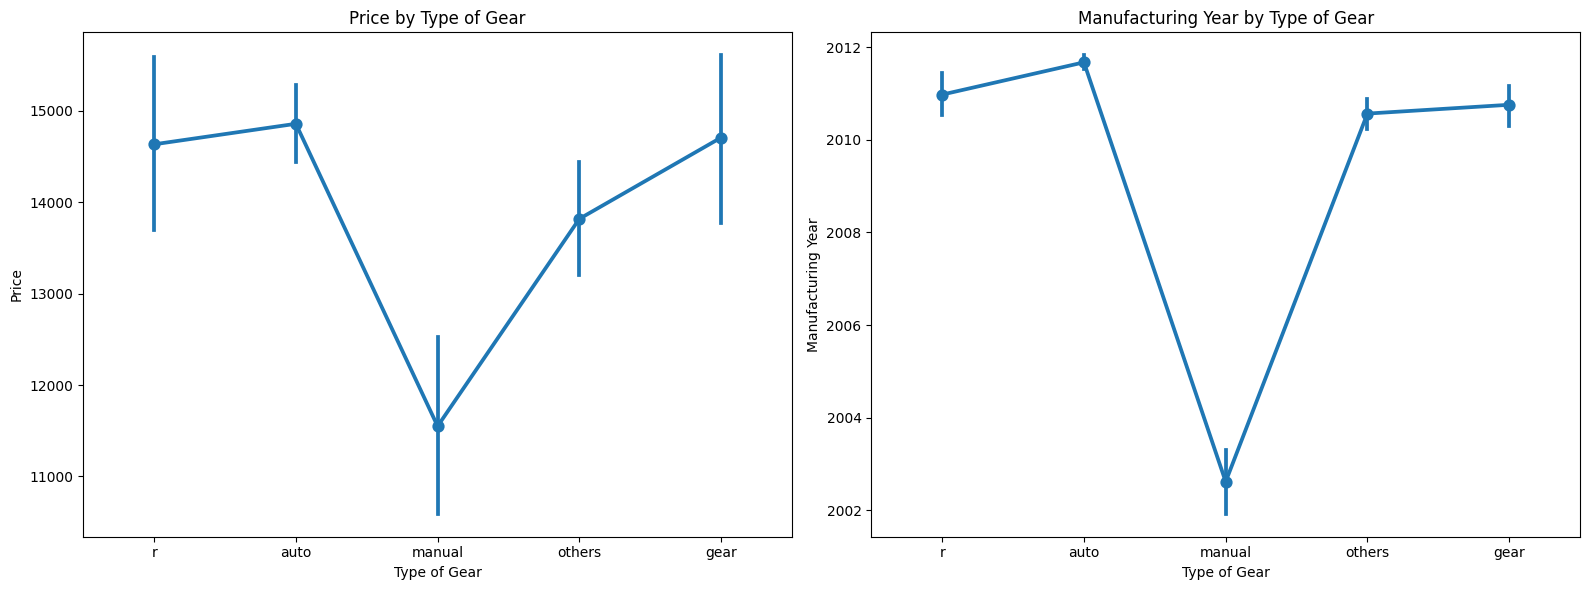

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.pointplot(
    data=train,
    x="type of gear",
    y="price",
    ax=ax1
)
ax1.set_title("Price by Type of Gear")
ax1.set_xlabel("Type of Gear")
ax1.set_ylabel("Price")

sns.pointplot(
    data=train,
    x="type of gear",
    y="ManufacturingYear",
    ax=ax2
)
ax2.set_title("Manufacturing Year by Type of Gear")
ax2.set_xlabel("Type of Gear")
ax2.set_ylabel("Manufacturing Year")

plt.tight_layout()
plt.show()

In [63]:
train['type of gear'] = train['type of gear'].replace({
    'others': 'auto',
    'gear': 'auto',
    'r': 'auto'
})

In [64]:
test['type of gear'] = test['type of gear'].replace({
    'others': 'auto',
    'gear': 'auto',
    'r': 'auto'
})

### `capacity` Column

In [65]:
train['capacity'].str.contains('Turbo').sum()

587

This processes the `capacity` column and creates a new `motorType` column:

1. Creates the `motorType` column by checking if the `capacity` column contains the word 'Turbo'. 
   - Sets `motorType` to 'turbo' if 'Turbo' is present.
   - Sets `motorType` to 'normal' if 'Turbo' is not present.

2. Removes the substring ' Turbo' from the `capacity` column and converts the remaining values to float type.

In [66]:
train['motorType'] = (
    train['capacity']
    .str.contains('Turbo')
    .replace({True: 'turbo', False: 'normal'})
)

train['capacity'] = train['capacity'].str.replace(' Turbo', '').astype(float)

In [67]:
test['motorType'] = (
    test['capacity']
    .str.contains('Turbo')
    .replace({True: 'turbo', False: 'normal'})
)

test['capacity'] = test['capacity'].str.replace(' Turbo', '').astype(float)

In [68]:
train['capacity'].value_counts()

capacity
2.0    1383
2.5     796
0.0     714
1.8     672
1.6     550
1.5     474
2.4     368
3.5     368
3.0     332
1.3     204
1.4     170
2.2     135
4.6      93
3.3      78
1.7      67
3.2      64
2.7      56
4.7      41
1.2      37
3.6      36
1.0      35
2.3      33
4.4      33
4.0      29
3.7      25
1.9      25
5.0      24
5.5      21
2.8      19
5.7      19
4.8      10
0.4       8
2.6       7
2.9       7
6.2       6
4.2       6
0.7       6
4.5       6
3.8       5
0.6       4
2.1       4
4.3       4
5.4       3
0.2       3
0.8       3
5.3       2
1.1       2
3.4       2
0.1       2
5.9       2
6.7       1
0.3       1
0.9       1
5.6       1
5.2       1
6.3       1
0.5       1
Name: count, dtype: int64

In [69]:
train.loc[train['capacity'] == 0, 'capacity'] = np.nan
test.loc[test['capacity'] == 0, 'capacity'] = np.nan

### `Odometer` Column

In [70]:
train['Odometer'].unique()

array(['75492 KM', '220000 KM', 'TOTAL 50653 km', ..., '156802  kilo',
       '314373 KM', '131627'], dtype=object)

In [71]:
train['Odometer'] = (
    train['Odometer']
    .str.lower()
    .str.replace('km', '')
    .str.replace('total', '')
    .str.replace('kilometer', '')
    .str.replace('kilo', '')
    .str.strip()
).astype(float)

In [72]:
test['Odometer'] = (
    test['Odometer']
    .str.lower()
    .str.replace('km', '')
    .str.replace('total', '')
    .str.replace('kilometer', '')
    .str.replace('kilo', '')
    .str.strip()
).astype(float)

In [73]:
train['Odometer'].describe()

count    7.000000e+03
mean     1.589344e+06
std      5.018431e+07
min      0.000000e+00
25%      7.453000e+04
50%      1.291280e+05
75%      1.904135e+05
max      2.147484e+09
Name: Odometer, dtype: float64

Here we categorizes the `Odometer` column into usage bins:

1. Defines `bins` to segment the `Odometer` values into four categories:
   - 'New' for values ≤ 0
   - 'Low' for values between 0 and 50,000
   - 'Medium' for values between 50,000 and 100,000
   - 'High' for values > 100,000

2. Uses `pd.cut` to assign these labels to the `Odometer` column and creates a new `usage` column in both DataFrames.

In [74]:
bins = [-np.inf, 0, 50000, 100000, np.inf]
labels = ['New', 'Low', 'Medium', 'High']

train['usage'] = pd.cut(train['Odometer'], bins=bins, labels=labels, right=True).astype('object')
test['usage'] = pd.cut(test['Odometer'], bins=bins, labels=labels, right=True).astype('object')

In [75]:
train['usage'].value_counts()

usage
High      4533
Medium    1321
Low        889
New        257
Name: count, dtype: int64

### `#airbags` Column

In [76]:
train['#airbags'].value_counts()

#airbags
12     830
4      828
0      349
8      248
4      233
      ... 
1&       1
1%       1
2_       1
2"       1
-95      1
Name: count, Length: 321, dtype: int64

In [77]:
train['#airbags'] = train['#airbags'].str.extract(r'(\d+)').astype(float)

In [78]:
test['#airbags'] = test['#airbags'].str.extract(r'(\d+)').astype(float)

In [79]:
train['#airbags'].value_counts()

#airbags
4.0       1870
12.0      1852
0.0        774
8.0        545
6.0        455
2.0        357
10.0       270
96.0        78
1012.0      77
88.0        69
104.0       60
100.0       59
112.0       57
1004.0      52
5.0         34
1.0         33
7.0         30
16.0        27
1000.0      25
1008.0      24
108.0       23
1002.0      22
106.0       22
98.0        21
9.0         19
92.0        18
94.0        17
11.0        16
90.0        13
1010.0      12
1006.0      11
3.0         11
110.0       10
102.0        9
14.0         7
1007.0       4
15.0         2
1005.0       2
116.0        2
13.0         2
99.0         1
105.0        1
1016.0       1
101.0        1
111.0        1
97.0         1
107.0        1
109.0        1
95.0         1
Name: count, dtype: int64

In [80]:
train['#airbags'].isna().sum()

0

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              6294 non-null   object 
 1   VehicleModel       6303 non-null   object 
 2   ManufacturingYear  6081 non-null   float64
 3   Type               6315 non-null   object 
 4   rating             6310 non-null   object 
 5   color              4876 non-null   object 
 6   Duty               4422 non-null   float64
 7   fuel               6390 non-null   object 
 8   CylinderCount      6282 non-null   float64
 9   type of gear       6308 non-null   object 
 10  capacity           6286 non-null   float64
 11  Odometer           7000 non-null   float64
 12  #airbags           7000 non-null   float64
 13  price              7000 non-null   int64  
 14  motorType          7000 non-null   object 
 15  usage              7000 non-null   object 
dtypes: float64(6), int64(1),

## EDA

### Split Numerical and Categorical Columns

In [82]:
all_cols = train.drop(columns='price').columns

categorical_cols = [i for i in all_cols if train[i].dtype == 'object']
numerical_cols = [i for i in all_cols if train[i].dtype != 'object']

print(categorical_cols)
print(numerical_cols)

['Brand', 'VehicleModel', 'Type', 'rating', 'color', 'fuel', 'type of gear', 'motorType', 'usage']
['ManufacturingYear', 'Duty', 'CylinderCount', 'capacity', 'Odometer', '#airbags']


In [83]:
train.isna().sum()

Brand                 706
VehicleModel          697
ManufacturingYear     919
Type                  685
rating                690
color                2124
Duty                 2578
fuel                  610
CylinderCount         718
type of gear          692
capacity              714
Odometer                0
#airbags                0
price                   0
motorType               0
usage                   0
dtype: int64

In [84]:
test.shape

(3000, 15)

In [85]:
test.isna().sum()

Brand                 294
VehicleModel          303
ManufacturingYear     396
Type                  315
rating                310
color                 876
Duty                 1107
fuel                  279
CylinderCount         312
type of gear          308
capacity              290
Odometer                0
#airbags                0
motorType               0
usage                   0
dtype: int64

In [86]:
train[numerical_cols].describe()

,ManufacturingYear,Duty,CylinderCount,capacity,Odometer,#airbags
count,6081.000000,4422.000000,6282.000000,6286.000000,7.000000e+03,7000.000000
mean,2010.734748,1893.451606,5.602674,2.268772,1.589344e+06,45.664429
std,5.369093,2810.567551,3.270880,0.831490,5.018431e+07,178.772417
min,1982.000000,87.000000,1.000000,0.100000,0.000000e+00,0.000000
25%,2009.000000,690.300000,4.000000,1.800000,7.453000e+04,4.000000
50%,2012.000000,891.000000,4.000000,2.000000,1.291280e+05,6.000000
75%,2014.000000,1291.000000,6.000000,2.500000,1.904135e+05,12.000000
max,2020.000000,12455.000000,18.000000,6.700000,2.147484e+09,1016.000000


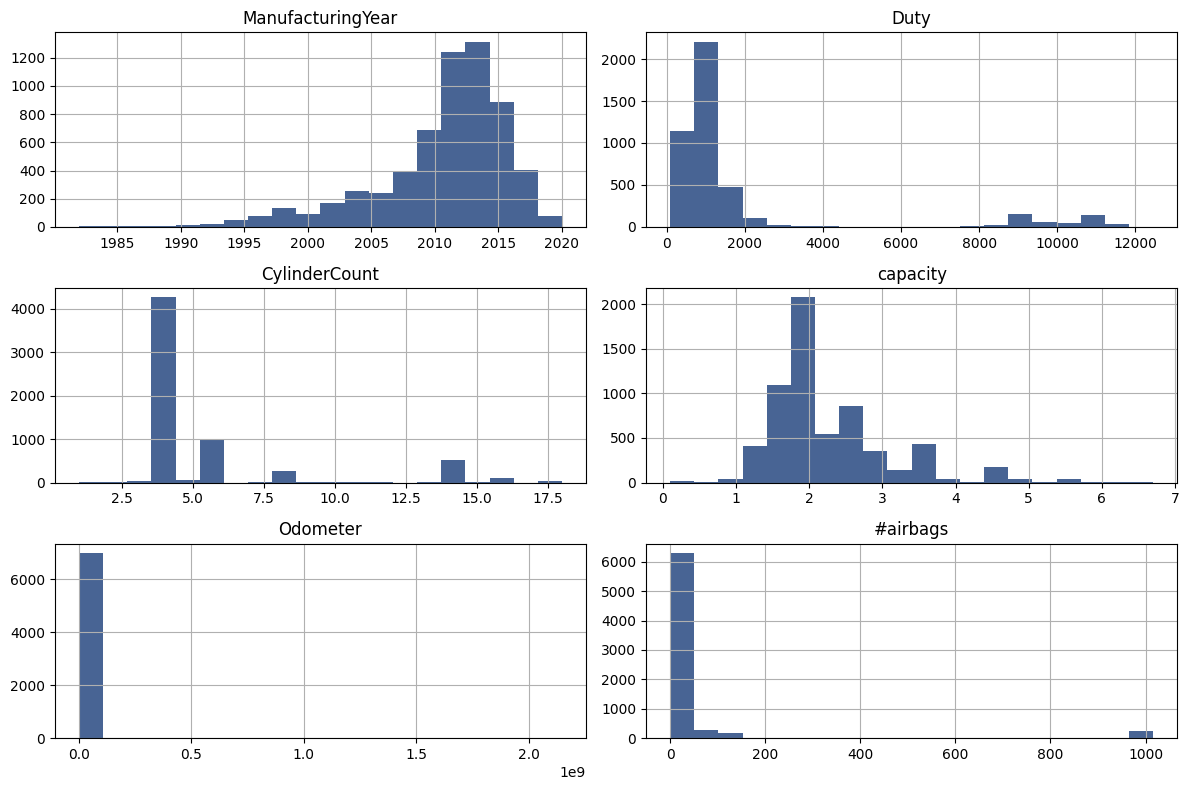

In [87]:
train[numerical_cols].hist(bins=20, figsize=(12, 8), color='#486494')
plt.tight_layout()
plt.show()

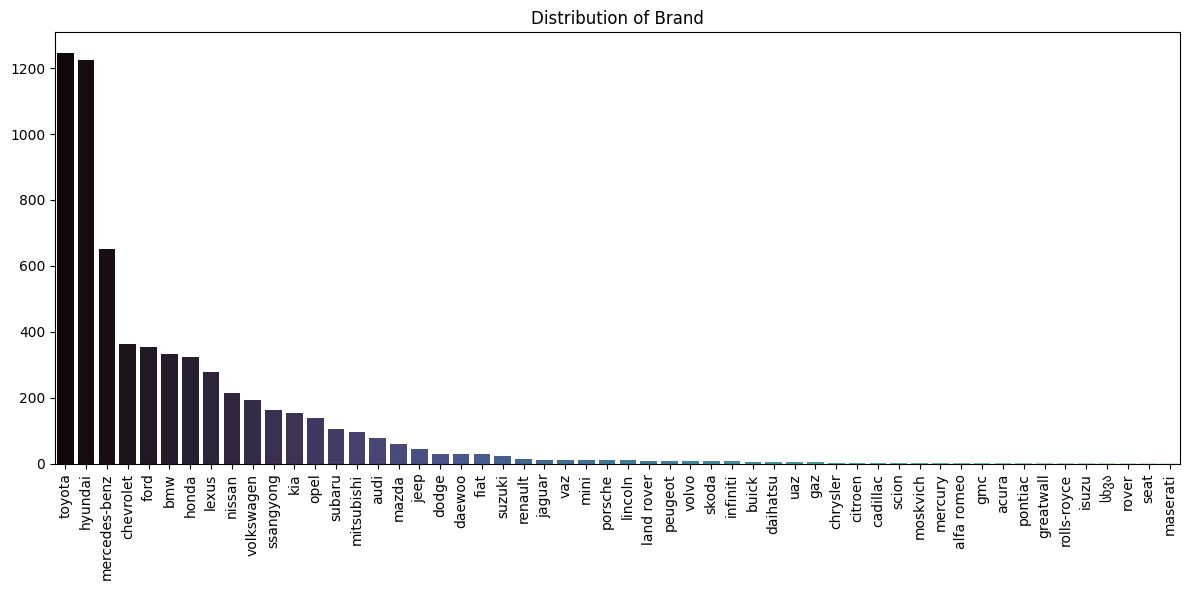

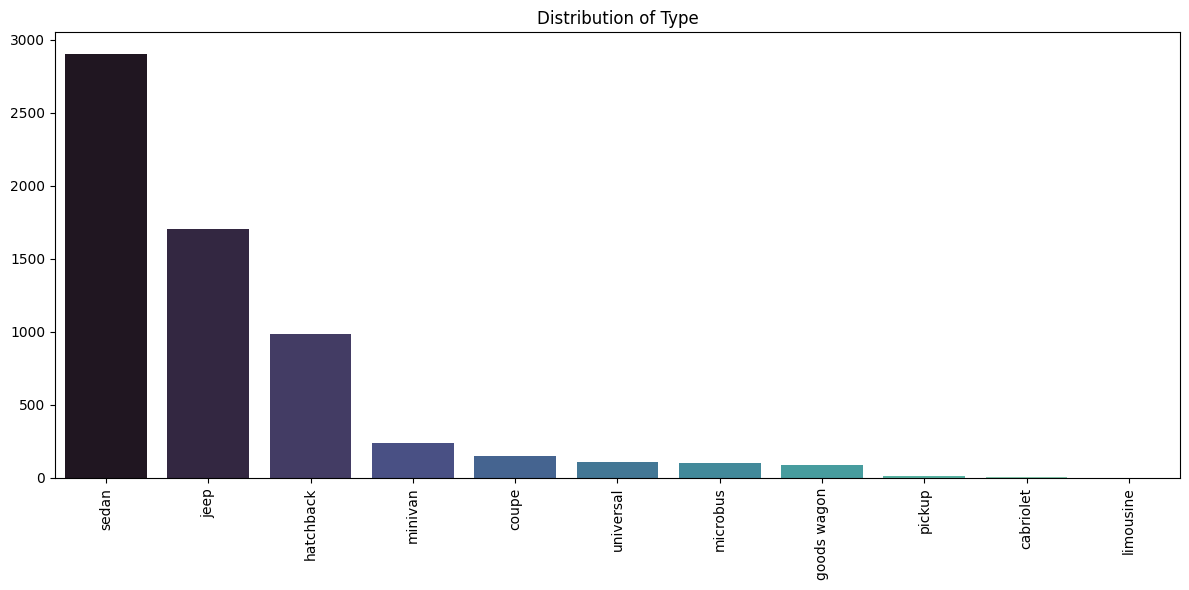

In [88]:
def plot_categorical_countplots(df, categorical_columns, n_cols=2, figsize=(12, 6)):
    n_cols = min(n_cols, len(categorical_columns))
    fig, axes = plt.subplots(1, n_cols, figsize=figsize, squeeze=False)

    for i, column in enumerate(categorical_columns):
        ax = axes[0, i]

        sns.countplot(
            data=df,
            x=column,
            ax=ax,
            palette='mako',
            order=df[column].value_counts().index
        )

        plt.xticks(rotation=90)
        ax.set_title(f'Distribution of {column}')
        ax.set_ylabel('')
        ax.set_xlabel('')

    for i in range(len(categorical_columns), n_cols):
        fig.delaxes(axes[0, i])

    plt.tight_layout()
    plt.show()


categorical_data_plot = categorical_cols.copy()
categorical_data_plot.remove('VehicleModel')

plot_categorical_countplots(train, categorical_data_plot[:1])
plot_categorical_countplots(train, categorical_data_plot[1:2])

for i in range(2, len(categorical_data_plot), 2):
    columns_to_plot = categorical_data_plot[i:i+2]
    plot_categorical_countplots(train, columns_to_plot)

## Univariate Analysis

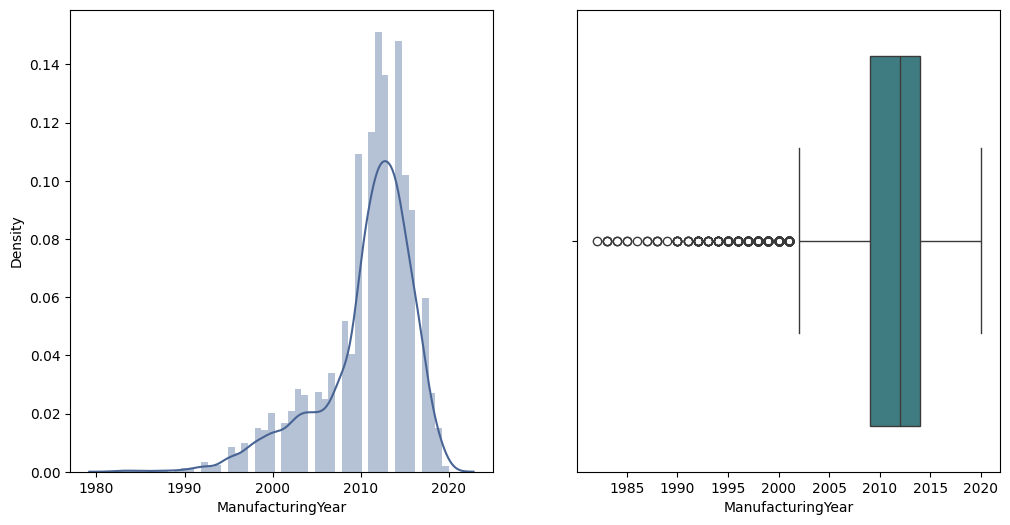

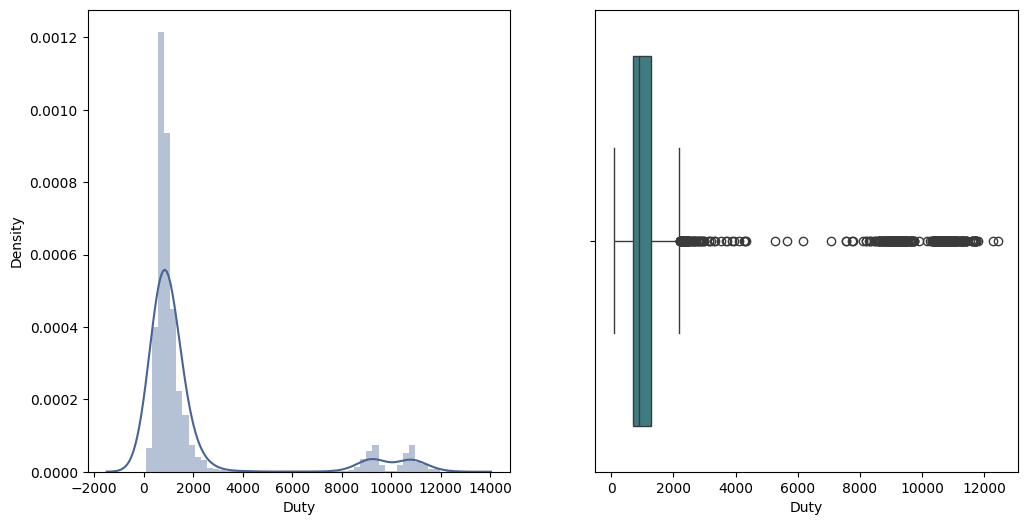

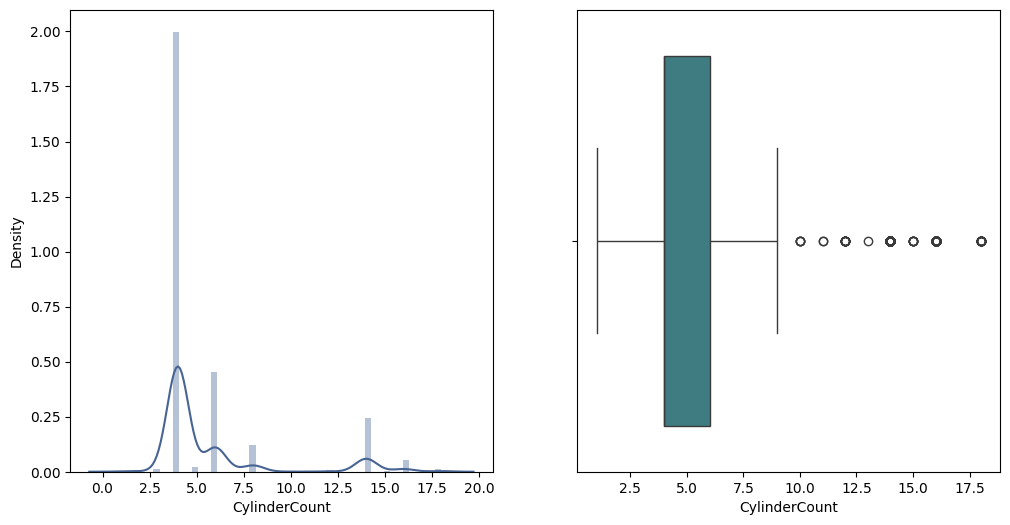

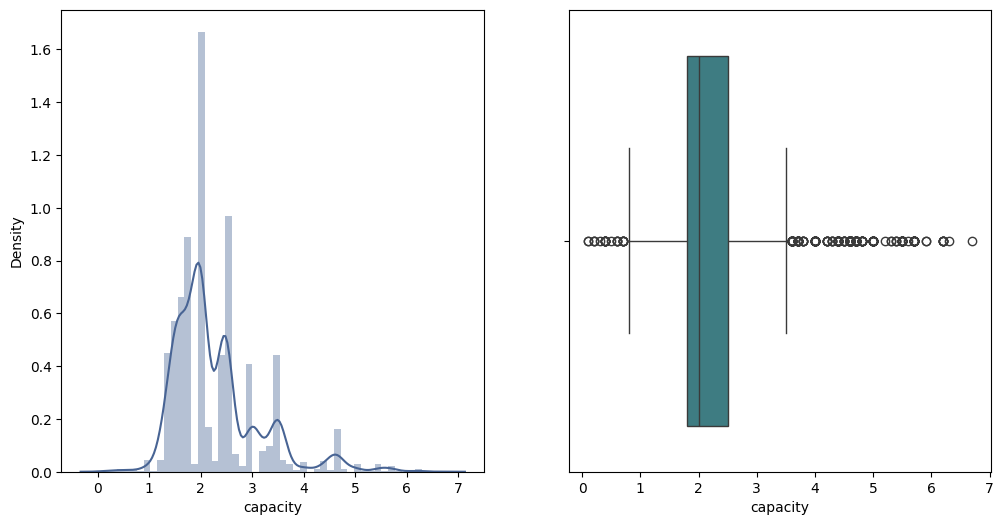

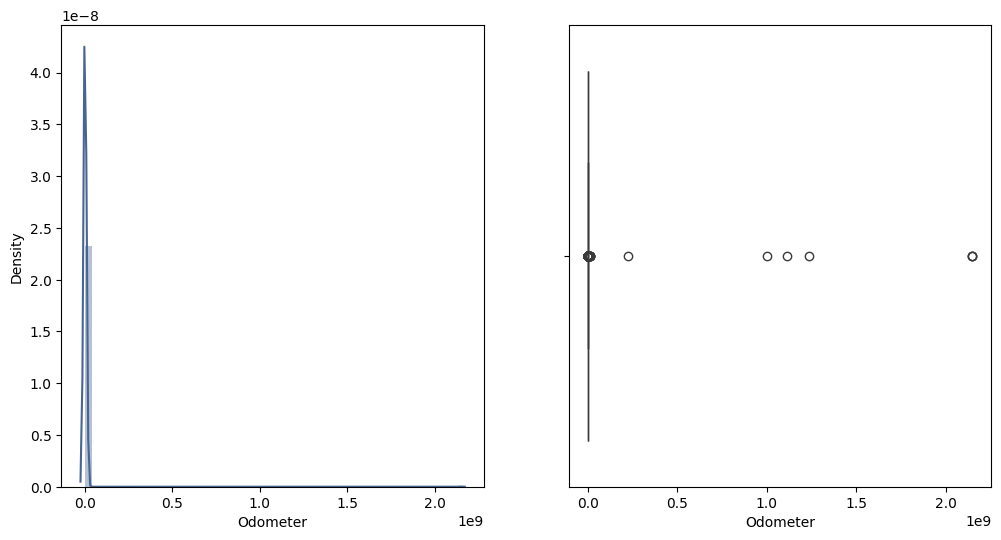

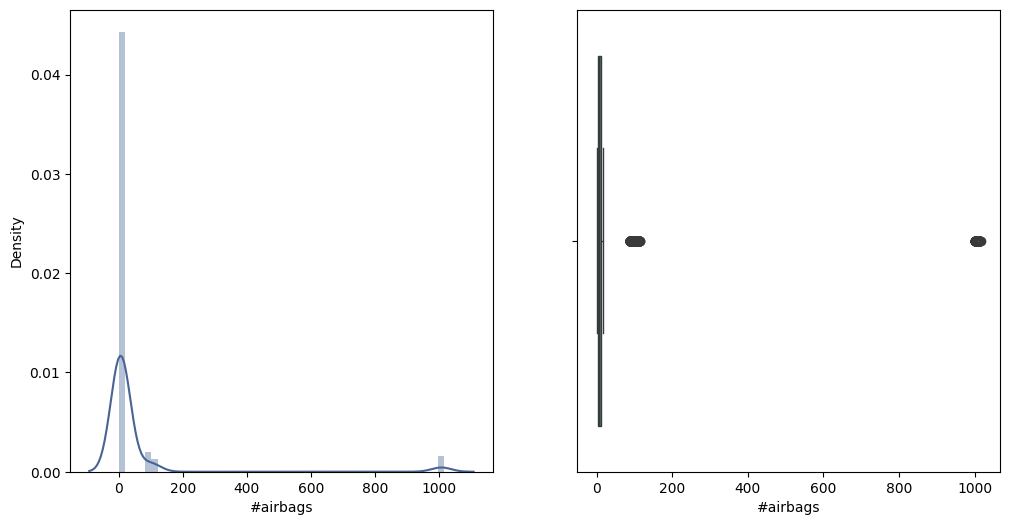

In [ ]:
for col in numerical_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.distplot(train[col], ax=ax[0], color='#486494')
    sns.boxplot(x=train[col], ax=ax[1], palette='crest')
    plt.show()

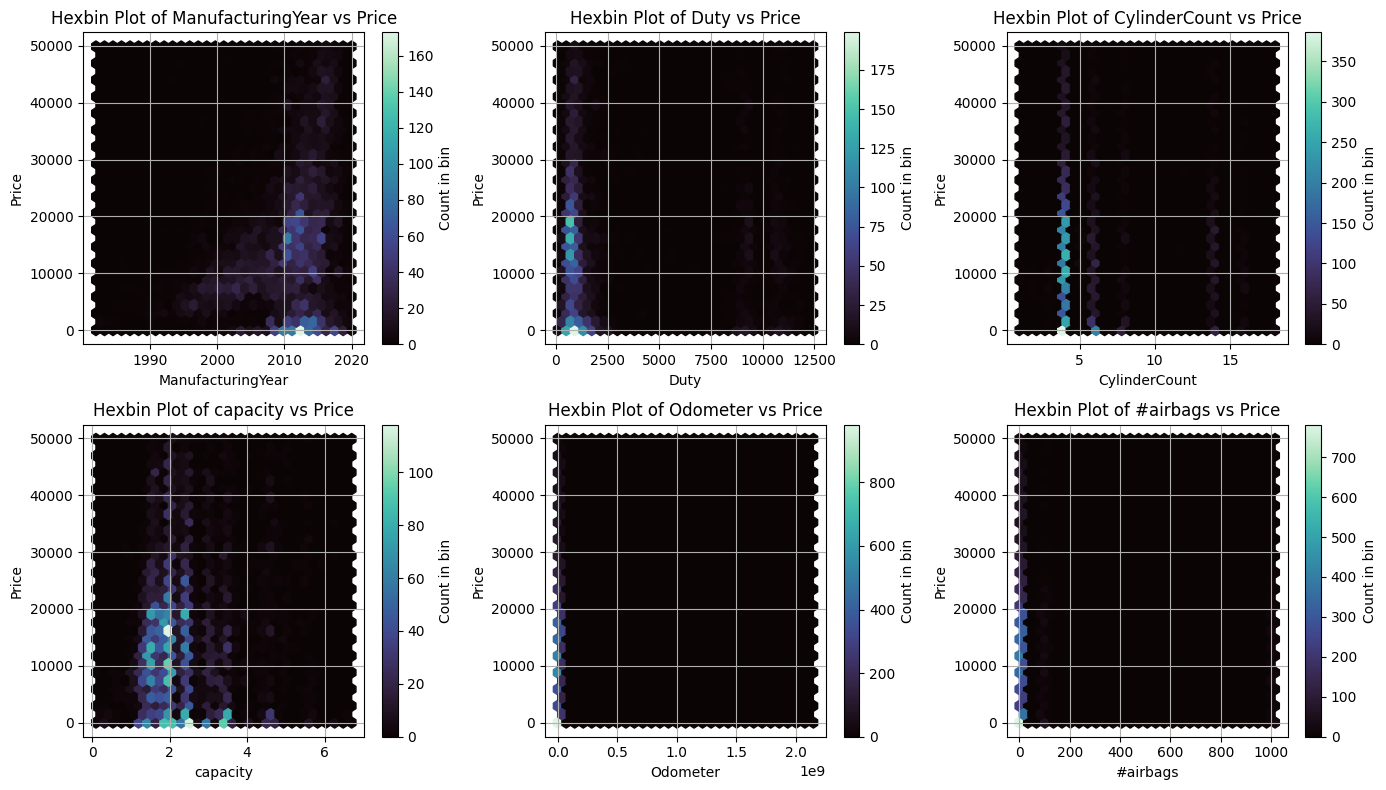

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    hb = ax.hexbin(
        train[col],
        train['price'],
        gridsize=30,
        cmap='mako'
    )

    ax.set_title(f'Hexbin Plot of {col} vs Price')
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    fig.colorbar(hb, ax=ax, label='Count in bin')
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

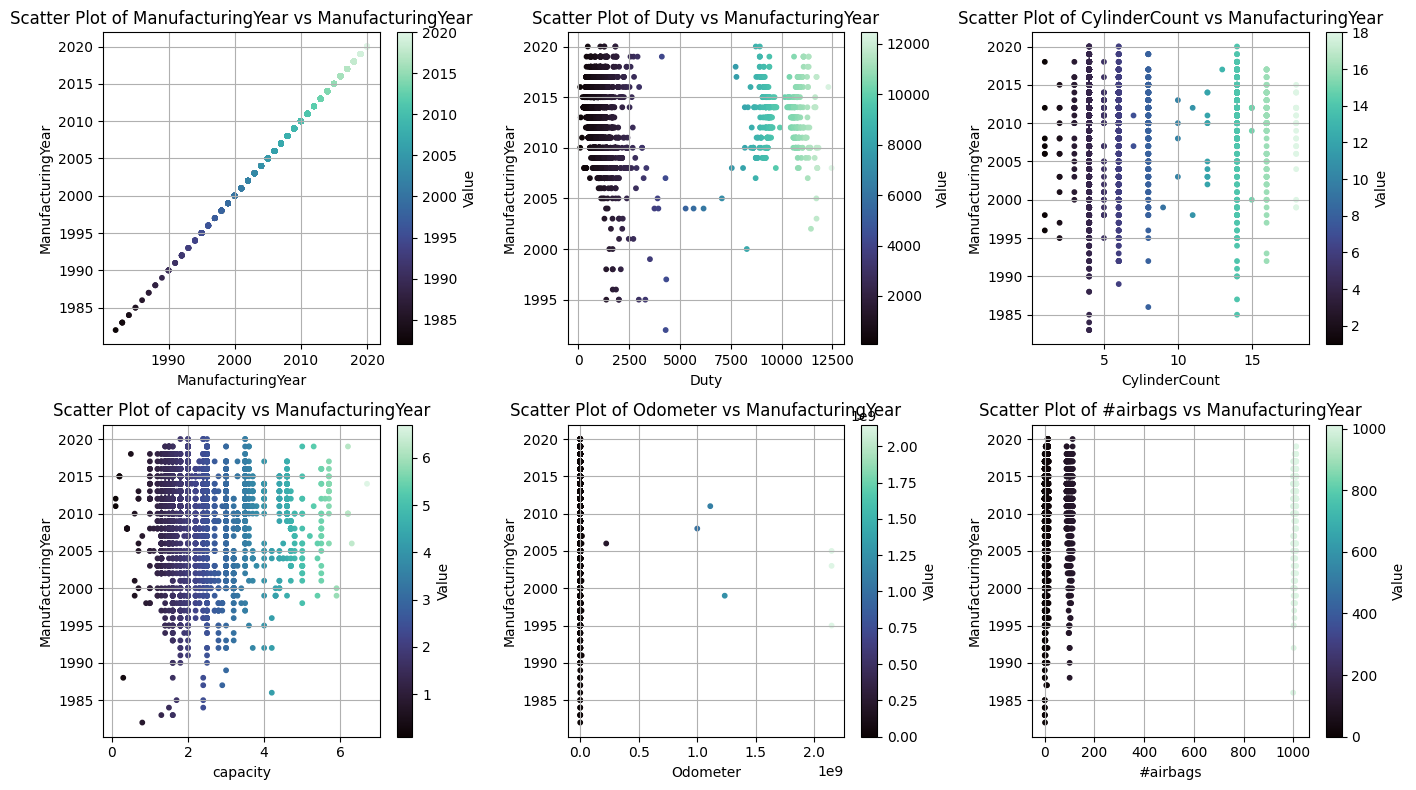

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    scatter = ax.scatter(
        train[col],
        train['ManufacturingYear'],
        c=train[col],
        cmap='mako',
        s=10
    )

    ax.set_title(f'Scatter Plot of {col} vs ManufacturingYear')
    ax.set_xlabel(col)
    ax.set_ylabel('ManufacturingYear')
    fig.colorbar(scatter, ax=ax, label='Value')
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

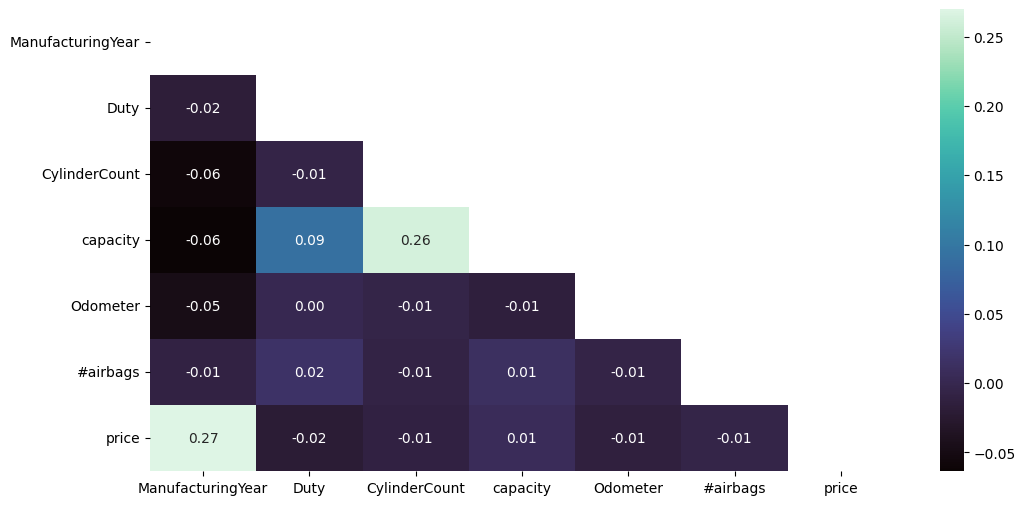

In [ ]:
corr = train.corr(numeric_only=True)
mask = np.triu(corr)

plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, mask=mask, cmap='mako', fmt='.2f')
plt.show()

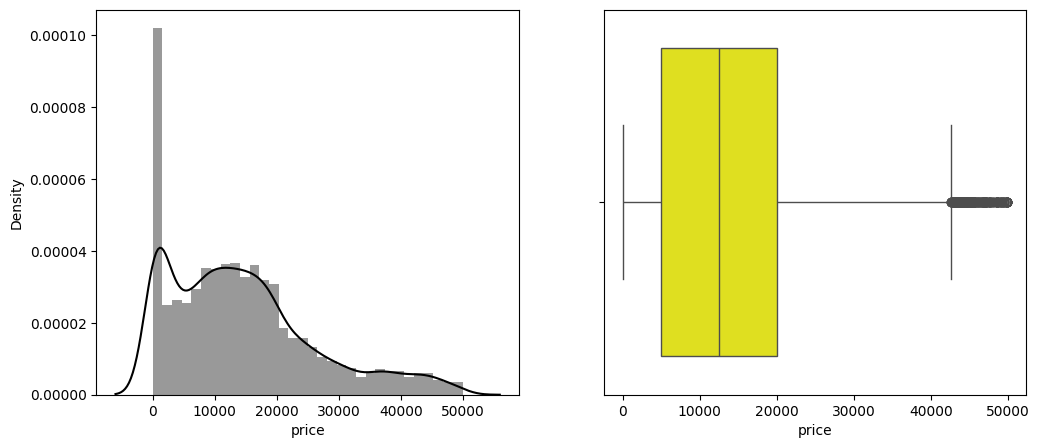

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.distplot(train['price'], ax=ax[0], color='black')
sns.boxplot(x=train['price'], ax=ax[1], color='yellow')
plt.show()

## Preprocessing

### Split Train and test 

In [ ]:
df_train = train.copy()
df_test = test.copy()

In [ ]:
X_train, y_train = df_train.drop(columns='price'), df_train['price']

### Numerical Column Skewness

In [ ]:
def detect_skewness(dataframe, threshold=0.5):
    """
    Detects left or right skewed columns in a pandas DataFrame.

    Parameters:
    dataframe (pandas DataFrame): The DataFrame to analyze.
    threshold (float): The threshold for considering a column as skewed.
                      Default is 0.5.

    Returns:
    skewed_columns (list): A list of column names that are skewed.
    """
    skewed_columns = []
    
    for column in dataframe.columns:
        skewness = dataframe[column].skew()
        if abs(skewness) > threshold:
            skewed_columns.append((column, skewness))
    
    return skewed_columns

In [ ]:
skewed_cols = detect_skewness(X_train[numerical_cols])
print("Skewed columns:", skewed_cols)

Skewed columns: [('ManufacturingYear', -1.3356818124570307), ('Duty', 2.546536938993165), ('CylinderCount', 2.1666234063791987), ('capacity', 1.4981247577927077), ('Odometer', 38.32369354719197), ('#airbags', 5.103779475757557)]


we used the `detect_skewness` function to identify skewed columns in the train df:

**Function Behavior:**
- Iterates through each column in the DataFrame.
- Calculates the skewness of each column using `dataframe[column].skew()`.
- Adds columns with skewness absolute value greater than the threshold to the `skewed_columns` list along with their skewness values.

**Output**
Skewed columns include:
- `ManufacturingYear` with skewness -1.33
- `Duty` with skewness 2.55
- `CylinderCount` with skewness 2.17
- `capacity` with skewness 1.50
- `Odometer` with skewness 38.32
- `#airbags` with skewness 5.10

The purpose is to identify columns with significant skewness for potential data transformation or normalization.


### Custom Transformers

In [ ]:
class StandardScaleTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply standard scaling to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    cols : list of str
        The names of the columns to apply standard scaling to.
    """
    def __init__(self, cols):
        self.cols = cols
        self.scaler_ = None

    def fit(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.loc[:, self.cols] = self.scaler_.transform(X_copy.loc[:, self.cols])
        return X_copy

    def fit_transform(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self.transform(X)

In [ ]:
class RobustScaleTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply standard scaling to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    cols : list of str
        The names of the columns to apply standard scaling to.
    """
    def __init__(self, cols):
        self.cols = cols
        self.scaler_ = None

    def fit(self, X, y=None):
        self.scaler_ = RobustScaler().fit(X.loc[:, self.cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.loc[:, self.cols] = self.scaler_.transform(X_copy.loc[:, self.cols])
        return X_copy

    def fit_transform(self, X, y=None):
        self.scaler_ = RobustScaler().fit(X.loc[:, self.cols])
        return self.transform(X)

In [ ]:
class DataFrameImputer(TransformerMixin, BaseEstimator):
    """
    A class to impute missing values in a Pandas DataFrame using a combination of median, knn, and most frequent
    imputers on specified columns.

    Parameters:
    -----------
    median_cols : list of str, optional (default=None)
        Columns to impute missing values using the median imputer.
    knn_cols : list of str, optional (default=None)
        Columns to impute missing values using the KNN imputer.
    freq_cols : list of str, optional (default=None)
        Columns to impute missing values using the most frequent imputer.
    const_cols : dict of {column_name: constant_value} pairs, optional (default=None)
        Columns to impute missing values using a constant value.

    Returns:
    --------
    X_imputed : pandas.DataFrame
        A DataFrame with imputed missing values.
    """
    def __init__(self, median_cols=None, knn_cols=None, freq_cols=None, const_cols=None, fill_const=0):
        self.median_cols = median_cols
        self.knn_cols = knn_cols
        self.freq_cols = freq_cols
        self.const_cols = const_cols
        self.fill_const = fill_const
    
    def fit(self, X, y=None):
        self.median_imputer = SimpleImputer(strategy='median')
        self.knn_imputer = KNNImputer()
        self.freq_imputer = SimpleImputer(strategy='most_frequent')
        self.const_imputer = SimpleImputer(strategy='constant', fill_value=self.fill_const)

        if self.median_cols is not None:
            self.median_imputer.fit(X[self.median_cols])
        if self.knn_cols is not None:
            self.knn_imputer.fit(X[self.knn_cols])
        if self.freq_cols is not None:
            self.freq_imputer.fit(X[self.freq_cols])
        if self.const_cols is not None:
            self.const_imputer.fit(X[self.const_cols])

        return self
    
    def transform(self, X):
        X_imputed = X.copy()
        if self.median_cols is not None:
            X_median = pd.DataFrame(self.median_imputer.transform(X[self.median_cols]), 
                                    columns=self.median_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.median_cols, axis=1), X_median], axis=1)
        if self.knn_cols is not None:
            X_knn = pd.DataFrame(self.knn_imputer.transform(X[self.knn_cols]), 
                                 columns=self.knn_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.knn_cols, axis=1), X_knn], axis=1)
        if self.freq_cols is not None:
            X_freq = pd.DataFrame(self.freq_imputer.transform(X[self.freq_cols]), 
                                  columns=self.freq_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.freq_cols, axis=1), X_freq], axis=1)
        if self.const_cols is not None:
            X_const = pd.DataFrame(self.const_imputer.transform(X[self.const_cols]), 
                                  columns=self.const_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.const_cols, axis=1), X_const], axis=1)
        return X_imputed
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [ ]:
class OutlierThresholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, q1=0.25, q3=0.75):
        self.column = column
        self.q1 = q1
        self.q3 = q3
    def outlier_threshhold(self, dataframe, column):
        Q1 = dataframe[column].quantile(self.q1)
        Q3 = dataframe[column].quantile(self.q3)
        iqr = Q3 - Q1
        up_limit = Q3 + 1.5 * iqr
        low_limit = Q1 - 1.5 * iqr
        return low_limit, up_limit

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.column:
            low_limit, up_limit = self.outlier_threshhold(X_copy, col)
            X_copy.loc[(X_copy[col] < low_limit), col] = low_limit
            X_copy.loc[(X_copy[col] > up_limit), col] = up_limit
        return X_copy

    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that drops specified columns from a DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to be dropped.
    return
    ------
        dataframe with dropped columns
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is None:
            return X
        else:
            return X.drop(self.columns,axis=1)

In [ ]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):

    """
    A transformer class to apply one-hot encoding to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to encode.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with the specified columns one-hot encoded.
    """

    def __init__(self, columns=None):
        self.columns = columns
        self.unique_values = {}
        self.feature_names_ = None

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns.tolist()
        self.unique_values = {col: X[col].unique() for col in self.columns}
        self.feature_names_ = self._get_feature_names()
        return self

    def _get_feature_names(self):
        feature_names = []
        for col in self.columns:
            for value in self.unique_values[col]:
                feature_names.append(f"{col}_{value}")
        return feature_names

    def transform(self, X):
        X_transformed = pd.DataFrame(index=X[self.columns].index)

        for col in self.columns:
            for value in self.unique_values[col]:
                X_transformed[f"{col}_{value}"] = (X[col] == value).astype(int)

        X = pd.concat([X, X_transformed], axis=1)
        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [ ]:
class LabelEncodeColumns(BaseEstimator, TransformerMixin):
    """
    A transformer class to encode categorical columns using LabelEncoder.

    Parameters
    ----------
    columns : list of str
        The names of the columns to be encoded.

    return
    ------
        encoded feature
    """
    def __init__(self, columns):
        self.columns = columns
        self.encoders_ = {}

    def fit(self, X, y=None):
        for col in self.columns:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders_[col] = encoder
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, encoder in self.encoders_.items():
            X_copy[col] = encoder.transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [ ]:
class LogTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply a log transform to a specified column in a Pandas DataFrame.

    Parameters
    ----------
    columns : str
        The name of the column to apply the log transform to.
    domain_shift : float
        The value to be added to the column before applying the log transform.
        
    return
    ------
        transformed feature
    """
    def __init__(self, columns, domain_shift=0):
        self.columns = columns
        self.domain_shift = domain_shift

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = np.log(X_copy[self.columns] + self.domain_shift)
        return X_copy

    def fit_transform(self, X, y=None):
        return self.transform(X)

#### Full Pipelines

Here we defined a `FullPipeline` class for preprocessing a DataFrame using a series of transformations:

1. **Initialization:**
   - Sets up columns for different types of transformations:
     - `OHE_cols`: Columns to be one-hot encoded.
     - `MLE_cols`: Columns to be label encoded and transformed.
     - `drop_col`: Columns to be dropped after processing.

   - Constructs a `Pipeline` object with several steps:
     - `impute_cat`: Imputes missing values in categorical columns using `DataFrameImputer`.
     - `impute_num`: Imputes missing values in numerical columns using `DataFrameImputer`.
     - `log_transformer`: Applies log transformation to numerical columns using `LogTransform`.
     - `label_encode`: Applies label encoding to specified columns using `LabelEncodeColumns`.
     - `one_hot_encode`: Applies one-hot encoding to specified columns using `CustomOneHotEncoder`.
     - `remove_outlier`: Removes outliers from numerical columns using `OutlierThresholdTransformer`.
     - `Robust_scale`: Scales numerical columns using `RobustScaleTransform`.
     - `drop`: Drops specified columns using `DropColumnsTransformer`.

2. **Methods:**
   - `fit_transform(X_train)`: Fits the pipeline to `X_train` and transforms it.
   - `transform(X_test)`: Transforms `X_test` using the fitted pipeline.

3. **Usage**
   - `f2 = FullPipeline()`: Instantiates the `FullPipeline` class.
   - `X_2_train_f2 = f2.fit_transform(X_train)`: Applies the full pipeline to the training data.
   - `X_2_test_f2 = f2.transform(df_test)`: Applies the fitted pipeline to the test data.

The purpose of this class is to streamline data preprocessing by chaining multiple transformation steps into a single pipeline.

In [ ]:
class FullPipeline:
    def __init__(self):
        self.cols = train.columns
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        
        self.OHE_cols = ['Brand', 'Type', 'color', 'VehicleModel', 'motorType']
        self.MLE_cols = ['type of gear', 'fuel', 'rating', 'usage']
        self.drop_col = ['Brand', 'Type', 'color', 'VehicleModel', 'motorType']

        self.full_pipeline = Pipeline([
            ('impute_cat', DataFrameImputer(freq_cols=self.categorical_cols)),
            ('impute_num', DataFrameImputer(knn_cols=self.numerical_cols)),
            ('log_transformer', LogTransform(columns=numerical_cols)),
            ('label_encode', LabelEncodeColumns(columns=self.MLE_cols)),
            ('one_hot_encode', CustomOneHotEncoder(columns=self.OHE_cols)),
            ('remove_outlier', OutlierThresholdTransformer(column=self.numerical_cols)),
            ('Robust_scale', RobustScaleTransform(cols=self.numerical_cols)),
            ('drop', DropColumnsTransformer(columns=self.drop_col))
        ])

    def fit_transform(self, X_train):
        X_train = self.full_pipeline.fit_transform(X_train)
        return X_train

    def transform(self, X_test):
        X_test = self.full_pipeline.transform(X_test)
        return X_test


f2 = FullPipeline()
X_train = f2.fit_transform(X_train)
df_test = f2.transform(df_test)

In [ ]:
f2

## Feature Importance

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
feature_importance_df

,Feature,Importance
4,ManufacturingYear,1.563839e-01
8,Odometer,1.298858e-01
9,#airbags,1.287197e-01
7,capacity,8.087292e-02
5,Duty,5.741544e-02
...,...,...
477,VehicleModel_berlingo,4.590060e-09
314,VehicleModel_durango,4.426904e-09
413,VehicleModel_s70,4.231644e-09
196,VehicleModel_cami,3.170224e-09


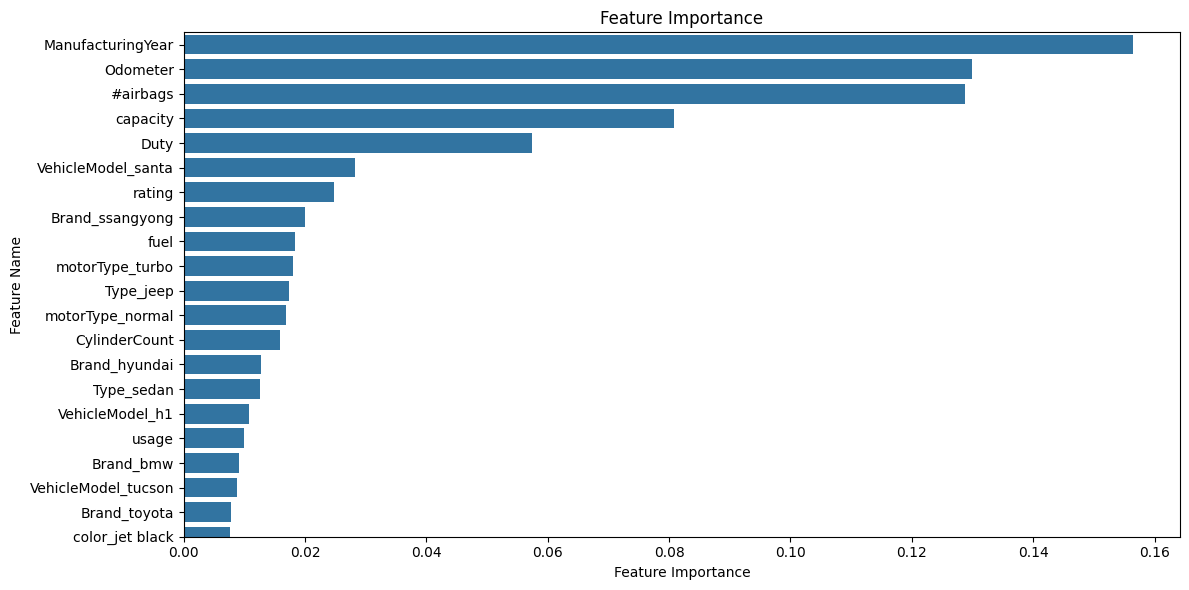

In [ ]:
plt.figure(figsize=(12, 6))
fig = sns.barplot(
    y='Feature',
    x='Importance',
    data=feature_importance_df,
)

plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')

fig.set_ylim(20)
plt.tight_layout()

## Modeling

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Finding The Best Model

In this section we tried to evaluate the performance of various regression models on the test data:

1. **Lists for Storing Results:**
   - `model_name`: To store the names of the models.
   - `r2score`: To store the R² scores of the models.
   - `mae`: To store the Mean Absolute Errors (MAE) of the models.

2. **Models List:**
   - A list of regression models to be evaluated:
     - `SVR()`
     - `LinearRegression()`
     - `GradientBoostingRegressor(random_state=42)`
     - `RandomForestRegressor(random_state=42)`
     - `ExtraTreesRegressor(random_state=42)`
     - `AdaBoostRegressor(random_state=42)`
     - `DecisionTreeRegressor(random_state=42)`
     - `XGBRegressor(random_state=42)`
     - `XGBRFRegressor(random_state=42)`
     - `CatBoostRegressor(random_state=42, verbose=False)`

3. **Loop for Model Evaluation:**
   - Iterates over each model in the `models` list:
     - Fits the model on `X_train_2` and `y_train_2`.
     - Predicts target values on `X_test_2`.
     - Appends the model's name to `model_name`.
     - Calculates and appends the R² score (multiplied by 100) to `r2score`.
     - Calculates and appends the Mean Absolute Error (MAE) to `mae`.

In [ ]:
model_name = []
r2score = []
mae = []
models = [
    SVR(),
    LinearRegression(),
    GradientBoostingRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False)
]

for model in models:
    model.fit(X_train_2, y_train_2)
    y_pred = model.predict(X_test_2)
    model_name.append(model.__class__.__name__)
    r2score.append(r2_score(y_test_2, y_pred) * 100)
    mae.append(mean_absolute_error(y_test_2, y_pred))

In [ ]:
models_df = pd.DataFrame({
    "Model-Name": model_name,
    "R2_score": r2score,
    'MAE': mae
})

models_df = models_df.astype({"R2_score": float, "MAE": float})
models_df.sort_values("MAE", ascending=True)

,Model-Name,R2_score,MAE
3,RandomForestRegressor,6.029021e+01,5.059131e+03
4,ExtraTreesRegressor,5.750067e+01,5.113694e+03
9,CatBoostRegressor,5.962734e+01,5.492790e+03
7,XGBRegressor,5.663368e+01,5.556298e+03
2,GradientBoostingRegressor,5.049594e+01,6.251285e+03
6,DecisionTreeRegressor,2.484961e+01,6.523079e+03
8,XGBRFRegressor,4.371002e+01,6.806173e+03
5,AdaBoostRegressor,2.293809e+01,8.361676e+03
0,SVR,-2.435874e+00,9.181672e+03
1,LinearRegression,-5.599951e+22,2.909370e+13


### HyperParameter Tunning

Now we perform hyperparameter tuning for an `ExtraTreesRegressor` using `RandomizedSearchCV`:

1. **Parameter Grid (`param_grid`):**
   - Defines a range of hyperparameters to search:
     - `n_estimators`: Number of trees in the forest, ranging from 50 to 1000, with steps of 50.
     - `max_features`: Number of features to consider when looking for the best split (`'auto'`, `'sqrt'`, `'log2'`, or `None`).
     - `max_depth`: Maximum depth of the tree, ranging from 10 to 100, with steps of 10, plus `None`.
     - `min_samples_split`: Minimum number of samples required to split an internal node, ranging from 2 to 10.
     - `min_samples_leaf`: Minimum number of samples required to be at a leaf node, ranging from 1 to 10.
     - `bootstrap`: Whether bootstrap samples are used when building trees (`True` or `False`).

2. **Setup for `RandomizedSearchCV`:**
   - Initializes `ExtraTreesRegressor`.
   - Defines `mae_scorer` as a scorer function for Mean Absolute Error (MAE) where lower scores are better.
   - Configures `RandomizedSearchCV` with:
     - `estimator`: `extra_trees`.
     - `param_distributions`: `param_grid`.
     - `n_iter`: Number of parameter settings to sample (100).
     - `cv`: Number of cross-validation folds (5).
     - `verbose`: Level of verbosity (2).
     - `random_state`: Seed for reproducibility (42).
     - `n_jobs`: Number of jobs to run in parallel (-1 for using all processors).
     - `scoring`: Scoring metric (MAE).

3. **Model Fitting and Results:**
   - Fits the `RandomizedSearchCV` on `X_2_train_f2` and `y_train`.
   - Retrieves and prints the best hyperparameters and the best mean absolute error score.

In [ ]:
param_grid = {
    'n_estimators': np.arange(50, 1001, 50),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'bootstrap': [True, False]
}

extra_trees = ExtraTreesRegressor()

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

random_search = RandomizedSearchCV(
    estimator=extra_trees,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # Number of folds in cross-validation
    random_state=42,
    n_jobs=-1,
    scoring=mae_scorer,
    # verbose=2,
    verbose=False
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print("Best parameters found: ", random_search.best_params_)
print("Best mean absolute error: ", -random_search.best_score_)

Best parameters found:  {'n_estimators': 750, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': False}

Best mean absolute error:  5348.1484619047615


In [ ]:
final_model = ExtraTreesRegressor(**best_params)

In [ ]:
final_model.fit(X_train, y_train)

ExtraTreesRegressor(max_features=None, min_samples_split=4, n_estimators=750)

In [ ]:
X_sub = df_test
id = id_test
y_sub = final_model.predict(X_sub)
y_sub = y_sub
id_data = pd.DataFrame(id)
id_data.columns.name = 'ID'
ids = id_data.values
sub = np.concatenate((ids, y_sub.reshape(-1, 1)), axis=1)
df_sub = pd.DataFrame(sub, columns=['ID', 'Price'])
df_sub['ID'] = df_sub['ID'].astype('int32')
df_sub.head()

,ID,Price
0,5634,10229.534889
1,16689,10672.724667
2,13457,8604.215333
3,4555,19847.505333
4,9726,9957.781111


In [ ]:
df_sub.to_csv('submission.csv', index=False)